# Machine learning compilation of quantum circuits
> Optimal compiling of unitaries reaching the theoretical lower bound

- toc: true 
- badges: true
- comments: true
- categories: [machine learning, compilation, qiskit, paper review]
- image: images/grovercirc.png

# Introduction

I am going to review a recent [preprint](http://arxiv.org/abs/2106.05649) by Liam Madden and
Andrea Simonetto that uses techniques from machine learning to tackle the problem of quantum circuits compilation. I find the approach suggested in the paper very interesting and the preliminary results quite promising.

## What is compilation?
> Note that a variety of terms are floating around the literature and used more or less interchangibly. Among those are **synthesis**, **compilation**, **transpilation** and **decomposition** of quantum circuits. I will not make a distinction and try to stick to **compilation**.

But first things first, what is a compilation of a quantum circuit? The best motivation and illustration for the problem is the following. Say you need to run a textbook quantum circuit on a real hardware. The real hardware usually allows only for a few basic one and two qubit gates. In contrast, your typical textbook quantum circuit may feature (1) complex many-qubit gates, for example multi-controlled gates and (2) one and two qubit gates which are not supported by the hardware. As a simple example take this 3-qubit Grover's circuit (from [qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html)):

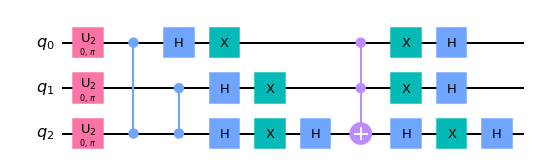

In [1]:
# collapse
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit = grover_circuit.decompose()
grover_circuit.draw(output='mpl')

The three qubit gates like Toffoli are not generally available on a hardware and one and two qubit gates my be different from those in the textbook algorithm. For example ion quantum computers are good with [Mølmer–Sørensen gates](https://en.wikipedia.org/wiki/M%C3%B8lmer%E2%80%93S%C3%B8rensen_gate) and may need several native one qubit gates to implement the Hadamard gate.

Additional important problem is to take into account qubit connectivity. Usually textbook algorithms assume full connectivity, meaning that two-qubit gates can act on any pair of qubits. On most hardware platforms however a qubit can only interact with its neighbors. Assuming that one and two qubits gates available on the hardware can implement a SWAP gate between adjacent qubits, to solve the connectivity problem one can insert as many SWAPs as necessary to connect topologically disjoint qubits. Using SWAPs however leads to a huge overhead in the number of total gates in the compiled circuit, and it is of much importance use them as economically as possible. In fact, the problem of optimal SWAPping alone in generic situation is [NP-complete](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=on+the+complexity+of+quantum+circuit+compilation&btnG=).

## Simplified problem
When compiling a quantum circuit one has to decide which resulting circuits are considered to be efficient. Ideally, one should optimize for the total fidelity of the circuit. Let us imagine running the algorithm on a real device. Probably my theorist's image of a real device is still way too platonic, but I will try my best. Many details need to be taken into account. For example, gates acting on different qubits or pairs of qubits may have different fidelities. Decoherence of qubits with time can make circuits where many operations can be executed in parallel more favorable. Cross-talk (unwanted interactions) between neighboring qubits may lead to exotic patterns for optimal circuits. A simple proxy for the resulting fidelity that is often adopted is the number of two-qubit gates (which are generically much less accurate than a single-qubit gates). So the problem that is often studied, and that is addressed in the preprint we are going to discuss, is the problem of optimal compilation into a gate set consisting of arbitrary single-qubit gates and CNOTs, the only two qubits gate. The compiled circuit must 

1. Respect hardware connectivity.
1. Have as few CNOTs as possible.
1. Exceed a given fidelity threshold.

Last item here means that we also allow for an approximate compilation. By increasing the number of CNOTs one can always achieve an exact compilation, but since in reality each additional CNOT comes with its own fidelity cost this might not be a good trade-off. Note also that a specific choice for two-qubit gate is made, a CNOT gate. Any two-qubit gate can be decomposed into at most 3 CNOTs [see e.g. here](https://arxiv.org/pdf/quant-ph/0308006.pdf), so in terms of computational complexity this is of course inconsequential. However in the following discussion we will care a lot about constant factors and may wish to revisit this choice at the end.

## Existing results 

Since finding the exact optimal solution to the compilation problem is intractable, as with many things in life one needs to resort to heuristic methods. A combination of many heuristic methods, in fact. As an example one can check out the [transpilation workflow](https://qiskit.org/documentation/apidoc/transpiler.html) in `qiskit`. Among others, there is a step that compiles >2 qubit gates into one and two qubit gates; the one that tries to find a good initial placement of the logical qubits onto physical hardware; the one that 'routes' the desired circuit to match a given topology being as greedy on SWAPs as possible. Each of these steps can use several different heuristic optimization algorithms, which are continuously refined and extended (for example this [recent preprint](https://arxiv.org/abs/2106.06446) improves on the default rounting procedure in `qiskit`). In my opinion it would be waay better to have one unified heuristic for all steps of the process, especially taking into account that they are not completely independent. Although this might be too much to ask for, some advances are definitely possible and machine learning tools might prove very useful. The paper we are going to discuss is an excellent demonstration.

## Theoretical lower bound and quantum Shannon decomposition
There is a couple of very nice theoretical results about the compilation problem that I need to mention. But first, let us agree that we will compile unitaries, not circuits.  What is the difference? Of course, any quantum circuit (without measurements and neglecting losses) corresponds to a unitary matrix. However, to compute that unitary matrix for a large quantum circuit explicitly is generally an intractable problem, precisely for the same reasons that quantum computation is assumed to be more powerful than classical. Still, taking as the input a unitary matrix (which is in general hard to compute from the circuit) is very useful both theoretically and practically. I will discuss pros and cons of this approach later on.

OK, now the fun fact. Generically, one needs at least this many CNOTs

\begin{align}
 L:=\# \text{CNOTs} \geq \frac14\left(4^n-3n-1\right) \label{TLB}
\end{align}

to exactly compile an $n$-qubit unitary. 'Generically' means that the set of $n$-qubit unitaries that can be compiled exactly with smaller amount of CNOTs has measure zero. Keep in mind though, that there are important unitaries in this class like multi-controlled gates or qubit permutations. We will discuss compilation of some gates from the 'measure-zero' later on. 

The authors of the preprint (I hope you and me still remember that there is some actual results to discuss, not just my overly long introduction to read) refer to \eqref{TLB} as the theoretical lower bound or TLB for short. The proof of this [fact](https://dl.acm.org/doi/10.5555/968879.969163) is actually rather simple and I will sketch it. A general $d\times d$ unitary has $d^2$ real parameters. For $n$ qubits $d=2^n$. Single one-qubit gate has 3 real parameters. Any sequence of one-qubit gates applied to the same qubit can be reduced to a single one-qubit gate and hence can have no more than 3 parameters. That means, that without CNOTs we can only have 3n parameters in our circuit, 3 for each one-qubit gate. This is definitely not enough to describe an arbitrary unitary on $n$ qubits which has $d^2=4^n$ parameters.

Now, adding a single CNOT allows to insert two more 1-qubit unitaries after it, like that

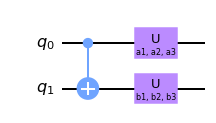

In [6]:
#collapse
from qiskit.circuit import Parameter

a1, a2, a3 = [Parameter(a) for a in ['a1', 'a2', 'a3']]
b1, b2, b3 = [Parameter(b) for b in ['b1', 'b2', 'b3']]

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.u(a1, a2, a3, 0)              
qc.u(b1, b2, b3, 1)
              
qc.draw(output='mpl')

At the first glance this allows to add 6 more parameters. However, each single-qubit unitary can be represented via the Euler angles as a product of only $R_z$ and $R_x$ rotations either as $U=R_z R_x R_z$ or $U=R_x R_y R_z$ (I do not specify angles). Now, CNOT can be represented as $CNOT=|0\rangle\langle 0|\otimes I+|1\rangle\langle 1|\otimes X$. It follows that $R_z$ commutes with the control of CNOT and $R_x$ commutes with the target of CNOT, hence they can be dragged to the left and joined with preceding one-qubit gates. So in fact each new CNOT gate allows to add only 4 real parameters:

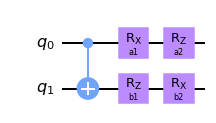

In [12]:
#collapse
a1, a2 = [Parameter(a) for a in ['a1', 'a2']]
b1, b2 = [Parameter(b) for b in ['b1', 'b2']]

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.rx(a1, 0)              
qc.rz(a2, 0)
qc.rz(b1, 1)
qc.rx(b2, 1)
              
qc.draw(output='mpl')

 That's it, there are no more caveats. Thus, the total number of parameters we can get with $L$ CNOTs is $3n+4L$ and we need to describe a $d\times d$ unitary which has $4^n$ parameters. In fact, the global phase of the unitary is irrelevant so we only need $3n+4L \geq 4^n-1$. Solving for $L$ gives the TLB \eqref{TLB}. That's pretty cool, isn't it?

Now there is an algorithm, called *quantum Shannon decomposition* (see [ref](https://arxiv.org/abs/quant-ph/0406176)), which gives an exact compilation of any unitary with the number of CNOTs twice as much as the TLB requires. In complexity-theoretic terms an overall factor of two is of course inessential, but for current NISQ devices we want to get as efficient as possible. Moreover, to my understanding the quantum Shannon decomposition is not easily extendable to restricted topology while inefficient generalizations lead to a much bigger overhead (roughly an order of magnitude).

# What's in the preprint?
## Templates
I've already wrote an introduction way longer than intended so from now on I will try to be brief and to the point. The authors of the preprint propose two templates inspired by the quantum Shannon decomposition. The building block for each template is a 'CNOT unit'

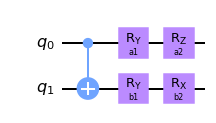

In [13]:
#collapse
a1, a2 = [Parameter(a) for a in ['a1', 'a2']]
b1, b2 = [Parameter(b) for b in ['b1', 'b2']]

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.ry(a1, 0)              
qc.rz(a2, 0)
qc.ry(b1, 1)
qc.rx(b2, 1)
              
qc.draw(output='mpl')

First template is called **sequ** in the paper and is obtained as follows. There are $n(n-1)/2$ different CNOTs on $n$-qubit gates. We enumerate them somehow and simply stack sequentially. Here is a 3-qubut example with two layers (I use `qiskit` gates `cz` instead of our 'CNOT units' for the ease of graphical representation)

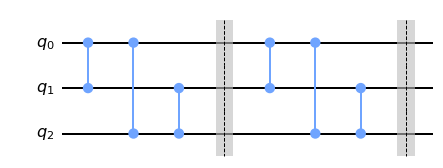

In [24]:
#collapse
qc = QuantumCircuit(3)
for _ in range(2):
    qc.cz(0, 1)
    qc.cz(0, 2)
    qc.cz(1, 2)
    qc.barrier()
qc.draw(output='mpl')

The second template is called **spin** and for 4 qubits looks as follows

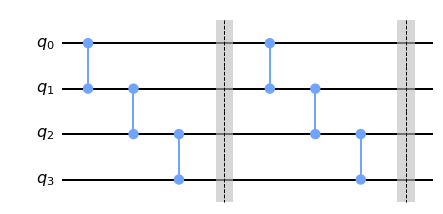

In [25]:
#collapse
qc = QuantumCircuit(4)
for _ in range(2):
    qc.cz(0, 1)
    qc.cz(1, 2)
    qc.cz(2, 3)
    qc.barrier()
qc.draw(output='mpl')

I'm sure you get the idea. That's it! The templates fix the pattern of CNOTs while angles of single-qubit gates are adjustable parameters which are collectively denoted by $\theta$. 

The idea now is simple. Try to optimize these parameters to achieve the highest possible fidelity for a given target unitary to compile. I am not at all an expert on the optimization methods, so I might miss many subtleties, but on the surface the problem looks rather straightforward. You can choose your favorite flavor of the gradient descent and hope for convergence. The problem appears to be non-convex but the gradient descent seems to work well in practice. One technical point that I do not fully understand is that the authors choose to work with fidelity defined by the Frobenius norm $||U-V||_F^2$ which is sensitive to the global phase of each unitary. To my understanding they often find that local minima of this fidelity coincides with the global minimum up to a global phase. OK, so in the rest of the post I refer to the 'gradient descent' as the magic numerical method which does good job of finding physically sound minimums.

## Results
### Compiling random unitaries
OK, finally, for the surprising results. The authors find experimentally that both **sequ** and **spin** perform surprisingly well on random unitaries always coming very close to the TLB \eqref{TLB} with good fidelity. More precisely, the tests proceed as follows. First, one generates a random unitary. Next, for each number $L$ of CNOTs below the TLB one runs the gradient descent to see how much fidelity can be achieved with this amount of CNOTs. Finally, one plots the fidelity as a function of $L$. Impressively, on the sample of hundred unitaries the fidelity always approaches 100% when the number of CNOTs reaches the TLB. For the $n=3$ qubits TLB is $L=14$, for $n=5$ $L=252$ (these are the two cases studied). So, in all cases studied, the gradient descent lead by the provided templates seems to always find the optimal compilation circuit! Recall that this is two times better than quantum Shannon decomposition. Please see the original paper for nice plots that I do not reproduce here.


### Compiling on restricted topology
These tests were performed on the fully connected circuits. The next remarkable discovery is that restricting the connectivity does not to seem to harm the performance of the compilation! More precisely, the authors considered two restricted topologies in the paper, 'star' where all qubits are connected to single central one and 'line' where well, they are connected by links on a line. The **spin** template can not be applied to star topology, but it can be applied to line topology. The **sequ** template can be generalized to any topology by simply omitting CNOTs that are not allowed. Again, as examining a hundred of random unitaries on $n=3$ and $n=5$ qubits shows, the fidelity nearing 100% can be achieved right at the TLB in all cases, which hints that topology restriction may not be a problem in this approach at all! To appreciate the achievement, imagine decomposing each unitary via the quantum Shannon decomposition and then routing on restricted topology with swarms of SWAPs, a terrifying picture indeed. It would be interesting to compare the results against the performance of `qiskit` transpiler which is unfortunately not done in the paper to my understanding.

### Compiling specific 'measure zero' gates
Some important multi-qubit gates fall into the 'measure zero' set which can be compiled with a smaller amount of CNOTs than is implied by the TLB \eqref{TLB}. For example, 4-qubit Toffoli gate can be compiled with 14 CNOTs while the TLB requires 61 gates. Numerical tests show that the plain version of the algorithm presented above does not generically obtain the optimal compilation for special gates. However, with some tweaking and increasing the amount of attempts the authors were able to find optimal decompositions for a number of known gates such as 3- and 4-qubit Toffoli, 3-qubit Fredkin and 1-bit full adder on 4 qubits. The tweaking included randomly changing the orientation of some CNOTs (note that in both **sequ** and **spin** the control qubit is always at the top) and running many optimization cycles with random initial conditions. The best performing method appeared to be **sequ** with random flips of CNOTs. The whole strategy might look a bit fishy, but I would argue that it is not. My argument is simple: you only need to find a good compilation of the 4-qubit Toffoli *once*. After that you pat yourself on the back and use the result in all your algorithms. So it does not really matter how hard it was to find the compilation as long as you did not forget to write it down.

### Compressing the quantum Shannon decomposition
Finally, as a new twist on the plot the authors propose a method to compress the standard quantum Shannon decomposition (which is twice the TLB, remember?). The idea seems simple and works surprisingly well. The algorithm works as follows.
1. Compile a unitary exactly using the quantum Shannon decomposition.
1. Promote parameters in single-qubit gates variables (they have fixed values in quantum Shannon decomposition).
2. Add [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)-type regularization term, which forces one-qubit gates to have small parameters, ideally zero (which makes the corresponding gates into identities).
3. Run a gradient descent on the regularized cost function (fidelity+LASSO term). Some one-qubit gates will become identity after that (one might need to tune the regularization parameter here).
4. After eliminating identity one-qubit gates one can end up in the situation where there is a bunch of CNOTs with no single-qubit gates in between. There are efficient algorithms for reducing the amount of CNOTs in this case.  
5. Recall that the fidelity was compromised by adding regularization terms. Run the gradient descent once more, this time without regularization, to squeeze out these last percents of fidelity.

From the description of this algorithm it does not appear obvious that the required cancellations (elimination of single-qubit gates and cancellations in resulting CNOT clusters) is bound to happen, but the experimental tests show that they do. Again, from a bunch of random unitaries it seems that the $\times 2$ reduction to the TLB is almost sure to happen! Please see the preprint for plots.

## Weak spots
Although I find results of the paper largely impressive, a couple of weak spots deserve a mention.
### Limited scope of experiments
The numerical experiments were only carried out for $n=3$ and $n=5$ qubits which of course is not much. To see if the method keeps working as the number of qubits is scaled is sure very important. There may be two promblems. First, the templates can fail to be expressive enough for larger circuits. The authors hope to attack this problem from the theoretical side and show that the templates do fill the space of unitaries. Well, best of luck with that! Another potential problem is that although the templates work fine for higher $n$, the learning part might become way more challenging. Well, I guess we should wait and see. 
### Unitary as the input
As I discussed somewhere way above, for a realistic quantum computation we can not know the unitary matrix that we need to compile. If we did, there would no need in the quantum computer in the first place. I can make two objects here. First, we are still in the NISQ era and pushing the existing quantum computers to their edge is a very important task. Even if an algorithm can be simulated classically, running it on a real device might be invaluable. Second, even quantum circuits on 1000 qubits do not usually feature  100-qubit unitaries. So it could be possible to separate a realistic quantum circuit into pieces, each containing only a few qubits, and compile them separately.

# Final remarks
To me, the algorithms presented in the preprint seem to be refreshingly efficient and universal. At some level it appears to be irrelevant which exact template do we use. Near the theoretical lower bound they all perform similarly well, even on restricted topology. This might be a justification for choosing CNOT as the two-qubit gate, as this probably does not matter in the end! I'm really cheering for a universal algorithm like that to win the compilation challenge over a complicated web of isolated heuristics, which are currently state of the art.